# Inter-rater reliability (IRR) data analysis

This notebook analyzes the inter-rater reliability between the benchmark scores and teachers' scores during the experimental scoring session. 

Note: 
- The asterisks in the plot represent the two teachers with less teaching experience (<3 years) compared to the others (>15 years).
- 'Gray area' refers to type A responses (complex), while 'Non-gray area' refers to type B responses.

## Imports

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import re

In [2]:
# Remove display restrictions in dataframes
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

## Data

This section loads the benchmark AI scores for the biology and economics scoring sessions.
These scores represent the ground truth, referring to the scores that two raters previously agreed upon.
Each record contains a question id (1-4), a student id (1-8), a student number (1-32 to identify each unique student response) and the benchmark scores for two parts of the response.

### Benchmark scores

In [3]:
#Load and show sample of benchmark scores
bio_scores = pd.read_csv("firebase_log_data/bio_benchmark_scores.csv", sep=',')
eco_scores = pd.read_csv("firebase_log_data/eco_benchmark_scores.csv", sep=',')

print("Example of (Biology) benchmark scores:")
display(eco_scores.head())

Example of (Biology) benchmark scores:


,question_id,student_id,student_nr,ai_score_deel1,ai_score_deel2
0,1,0,0,1,1
1,1,1,1,1,1
2,1,2,2,0,1
3,1,3,3,1,1
4,1,4,4,1,0


### Teachers' scores

The teacher scoring data represents scores given by teachers on student responses in a digital scoring environment.

In [4]:
# Load teacher scoring data for biology and economics teachers

bio_datasets = {}
for name in ["Biology 1", "Biology 2", "Biology 3", "Biology 4", "Biology 5"]:
    filename = f"firebase_log_data/{name.replace(' ', '_')}.csv"
    bio_datasets[name] = pd.read_csv(filename)

eco_datasets = {}
for name in ["Economics 1", "Economics 2", "Economics 3", "Economics 4", "Economics 5"]:
    filename = f"firebase_log_data/{name.replace(' ', '_')}.csv"
    eco_datasets[name] = pd.read_csv(filename)

In [5]:
# Example teacher session score data
display(bio_datasets['Biology 1'].head(5))


,timestamp,time_only,question_id,studentId,student_nr,studentName,part,score,actionName,Waarom?,Verberg uitleg,Toon meest vergelijkbare antwoorden deel 1,Verberg meest vergelijkbare antwoorden deel 1,Toon meest vergelijkbare antwoorden deel 2,Verberg meest vergelijkbare antwoorden deel 2
0,2025-04-29 09:58:23.828000+00:00,09:58:23,1,1,1,Student 1,NaN,NaN,Waarom?,True,False,False,False,False,False
1,2025-04-29 09:59:03.282000+00:00,09:59:03,1,1,1,Student 1,part2,NaN,Toon meest vergelijkbare antwoorden deel 2,False,False,False,False,True,False
2,2025-04-29 09:59:19.106000+00:00,09:59:19,1,1,1,Student 1,part1,1.0,Score deel 1: 1,False,False,False,False,False,False
3,2025-04-29 09:59:47.362000+00:00,09:59:47,1,1,1,Student 1,part2,0.0,Score deel 2: 0,False,False,False,False,False,False
4,2025-04-29 10:00:28.544000+00:00,10:00:28,1,2,2,Student 2,NaN,NaN,Waarom?,True,False,False,False,False,False


## Data pre-processing

In [6]:
# The actions that were logged in the digital scoring environment (and relevant for IRR analysis)
filtered_actions = ['Waarom?', 'Verberg uitleg', 'Toon meest vergelijkbare antwoorden deel 1',  'Verberg meest vergelijkbare antwoorden deel 1', 'Toon meest vergelijkbare antwoorden deel 2', 'Verberg meest vergelijkbare antwoorden deel 2']

In [7]:
def pre_process_df(df, cap_to_n_students = 8):
    """
    Pre-processes teacher scoring session data to prepare it for inter-rater reliability analysis.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw log data containing teacher scoring session interactions
        Required columns in data: 'actionName', 'timestamp', 'studentName', 'studentId'
    
    cap_to_n_students : int or None, default=8
        Maximum number of unique students to include in analysis
    
    Returns:
    --------
    pandas.DataFrame
        Processed DataFrame with boolean action indicators, formatted timestamps,
        question IDs, and unique student numbering
    """
    for act in filtered_actions:
        df[act] = df['actionName'] == act

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['time_only'] = df['timestamp'].dt.strftime('%H:%M:%S')
    df.insert(1, 'time_only', df.pop('time_only'))

    last_student_0_index = 0 
    for index, row in df.head(25).iterrows():
        if row['studentName'] == 'Student 0' :  #Take out the demo student response data 
            last_student_0_index = index

    df = df.iloc[last_student_0_index:].reset_index(drop=True)

    df['question_id'] = 1 
    for index, row in df.iterrows():
        if index > 0:  
            if row['studentId'] == 1 and df.at[index-1, 'studentId'] != 1:
                df.loc[index:, 'question_id'] = df.loc[index:, 'question_id'] + 1

    if cap_to_n_students is not None:
        student_ids = df['studentId'].unique()[:cap_to_n_students]
        df = df[df['studentId'].isin(student_ids)].reset_index(drop=True)

    df.insert(2, 'question_id', df.pop('question_id'))

    largest_studentid= df['studentId'].max()
    df['student_nr'] = (df['question_id']-1) * largest_studentid +  df['studentId']
    
    df.insert(4, 'student_nr', df.pop('student_nr'))
    
    return df

In [8]:
def clean_teacher_scores(df):
    """
    Extract and organize teacher scoring data into a structured format.
    
    This function processes raw teacher scoring data by filtering valid numeric scores,
    then restructuring them into a wide format with separate columns for part1 and part2 scores.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw scoring data containing the columns 'student_nr', 'part', and 'score'
        
    Returns:
    --------
    pandas.DataFrame
        Restructured DataFrame with columns:
        - 'student_nr': Unique student identifier
        - 'score_part1': Score for the first part of the student's response
        - 'score_part2': Score for the second part of the student's response
    """
    df_scores_only = df[pd.notna(df['score']) & df['score'].apply(lambda x: isinstance(x, (int, float)))]
    
    df_scores = df_scores_only[['student_nr', 'part', 'score']].copy()
    df_scores.reset_index(drop=True, inplace=True)
    df_scores['score'] = df_scores['score'].astype(int)

    df_score_per_part = pd.DataFrame(columns=['student_nr', 'score_part1', 'score_part2'])
    unique_students = df_scores['student_nr'].unique()
    df_score_per_part['student_nr'] = unique_students

    for i, row in df_scores.iterrows(): 
        if row['part'] == 'part1':
            df_score_per_part.loc[df_score_per_part['student_nr'] == row['student_nr'], 'score_part1'] = row['score']
        elif row['part'] == 'part2':
            df_score_per_part.loc[df_score_per_part['student_nr'] == row['student_nr'], 'score_part2'] = row['score']

    return df_score_per_part

In [9]:
def stats_to_dataframe(stats_dict):
    """
    Convert a dictionary of inter-rater reliability statistics to a pandas DataFrame.
    
    Parameters:
    -----------
    stats_dict : dict
        Dictionary mapping dataset names to tuples of statistics.
        Each tuple should contain (kappa_score, confusion_matrix, agreement_percentage)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns:
        - 'Dataset': Name of the dataset
        - 'Kappa': Cohen's Kappa score 
        - 'Agreement': Raw agreement percentage
    """
    data = []
    for name, stats in stats_dict.items():
        if stats is not None:
            kappa, _, agreement = stats
            data.append({
                'Dataset': name,
                'Kappa': kappa,
                'Agreement': agreement
            })
        else:
            print(f"Warning: No valid statistics for {name}")
            data.append({
                'Dataset': name,
                'Kappa': float('nan'),
                'Agreement': float('nan')
            })
    return pd.DataFrame(data)

## Calculate inter-rater-reliabilities

In [10]:
def get_teacher_benchmark_reliability(teacher_df, benchmark_df):
    """
    Calculate inter-rater reliability metrics between teacher scores and benchmark scores.
    
    This function computes agreement statistics between two sets of ratings:
    - Cohen's Kappa: A statistical measure that accounts for chance agreement
    - Confusion matrix: Shows the distribution of score pairs between raters
    - Raw agreement percentage: The proportion of identical scores
    
    The function first finds common student responses in both datasets, then concatenates 
    scores from both parts of each response to create a single vector of ratings per rater.
    
    Parameters:
    -----------
    teacher_df : pandas.DataFrame
        DataFrame containing teacher scores with columns:
        - 'student_nr': Unique identifier for student responses
        - 'score_part1': Teacher's score for the first part of each response
        - 'score_part2': Teacher's score for the second part of each response
        
    benchmark_df : pandas.DataFrame
        DataFrame containing benchmark/AI scores with columns:
        - 'student_nr': Unique identifier for student responses
        - 'ai_score_deel1': Benchmark score for the first part of each response
        - 'ai_score_deel2': Benchmark score for the second part of each response
        
    Returns:
    --------
    tuple
        A tuple containing:
        - kappa (float): Cohen's Kappa coefficient 
        - cm (numpy.ndarray): Confusion matrix showing score distribution
        - agreement (float): Raw agreement percentage (0-1)
    """
    try:
        common_student_nrs = set(teacher_df['student_nr']).intersection(set(benchmark_df['student_nr']))
        teacher_scores = teacher_df[teacher_df['student_nr'].isin(common_student_nrs)]
        benchmark_scores = benchmark_df[benchmark_df['student_nr'].isin(common_student_nrs)]

        part1_teacher_scores = teacher_scores['score_part1'].astype(int).values
        part2_teacher_scores = teacher_scores['score_part2'].astype(int).values
        all_teacher_scores = np.concatenate((part1_teacher_scores, part2_teacher_scores))

        part1_benchmark_scores = benchmark_scores['ai_score_deel1'].astype(int).values
        part2_benchmark_scores = benchmark_scores['ai_score_deel2'].astype(int).values
        all_benchmark_scores = np.concatenate((part1_benchmark_scores, part2_benchmark_scores))

        kappa = cohen_kappa_score(all_teacher_scores, all_benchmark_scores)
        cm = confusion_matrix(all_teacher_scores, all_benchmark_scores)
        agreement = np.sum(np.diag(cm)) / np.sum(cm)

        return kappa, cm, agreement
    except Exception as e:
        print(f"Error calculating rater reliability: {e}")
        return float('nan'), None, float('nan') 

### Biology inter-rater reliabilities

In [11]:
# For biology teachers, Calculate the inter-rater reliability between the biology benchmark scores and teacher scores
bio_rater_statistics = {}
structured_bio_datasets = {}

for name, df in bio_datasets.items():
    structure_df = clean_teacher_scores(df)
    structured_bio_datasets[name] = structure_df
    common_students = set(structure_df['student_nr']).intersection(set(bio_scores['student_nr']))
    bio_rater_statistics[name] = get_teacher_benchmark_reliability(structure_df, bio_scores)

bio_rater_df = stats_to_dataframe(bio_rater_statistics)
display(bio_rater_df)

,Dataset,Kappa,Agreement
0,Biology 1,0.652174,0.828125
1,Biology 2,0.712000,0.859375
2,Biology 3,0.680982,0.846154
3,Biology 4,0.480203,0.750000
4,Biology 5,0.498531,0.750000


### Economics inter-rater reliabilities

In [12]:
# For economics teachers, Calculate the inter-rater reliability between the economics benchmark scores and teacher scores
eco_rater_statistics = {}
structured_eco_datasets = {}

for name, df in eco_datasets.items():
    structure_df = clean_teacher_scores(df)
    structured_eco_datasets[name] = structure_df
    common_students = set(structure_df['student_nr']).intersection(set(eco_scores['student_nr']))
    eco_rater_statistics[name] = get_teacher_benchmark_reliability(structure_df, eco_scores)

eco_rater_df = stats_to_dataframe(eco_rater_statistics)
display(eco_rater_df)

,Dataset,Kappa,Agreement
0,Economics 1,0.507042,0.821429
1,Economics 2,0.582938,0.828125
2,Economics 3,0.278515,0.734375
3,Economics 4,0.503067,0.777778
4,Economics 5,0.363636,0.750000


## IRR for interacted vs. not interacted student responses

### Interaction function

In [13]:
def convert_npint_strings_to_int_lists(df, column_name='student_nrs_clicked_why'):
    """
    Convert string representations of NumPy integer arrays to Python lists of integers
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the string column to convert
    column_name : str
        Name of the column containing the string representations
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with the specified column converted to lists of integers
    """

    result_df = df.copy()
    
    # Extract numbers from the string using regex
    def extract_numbers(s):
        if pd.isna(s):
            return []
        numbers = re.findall(r'np\.int\d*\((\d+)\)', s)  # This pattern matches the numbers inside np.int64()
        return [int(num) for num in numbers]
    
    result_df[column_name] = result_df[column_name].apply(extract_numbers)
    
    return result_df

### Load data

In [14]:
# Loads interaction data in correct format: a list of the student response numbers where a participant clicked to reveal XAI
bio_df = pd.read_csv("firebase_log_data/why_clicks_per_bio_teacher.csv")
eco_df = pd.read_csv("firebase_log_data/why_clicks_per_eco_teacher.csv")

bio_clicked_df = convert_npint_strings_to_int_lists(bio_df)
eco_clicked_df = convert_npint_strings_to_int_lists(eco_df)

display(bio_clicked_df.head())

,teacher,student_nrs_clicked_why
0,Biology 1,"[2, 4, 6, 8, 10, 12, 13, 14, 15, 16, 18, 23]"
1,Biology 2,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1..."
2,Biology 3,[4]
3,Biology 4,"[1, 8, 10, 13, 18, 25, 26, 28, 30]"
4,Biology 5,"[2, 4, 6, 7, 8, 10, 12, 13, 14, 18, 20, 27]"


### Biology interaction IRR

In [15]:
# Calculate inter-rater reliability for interacted vs non-interacted responses for biology teachers
interaction_bio_dataset = {}
interaction_bio_statistics = {}
not_interacted_bio_statistics = {}
bio_sample_sizes = []

for name, df in bio_datasets.items():
    structure_df = clean_teacher_scores(df)
    interacted_student_nrs = bio_clicked_df[bio_clicked_df['teacher'] == name]['student_nrs_clicked_why'].tolist()[0]
    interacted_df = structure_df[structure_df['student_nr'].isin(interacted_student_nrs)].reset_index(drop=True)
    interaction_bio_dataset[name] = interacted_df

    common_students = set(interacted_df['student_nr']).intersection(set(bio_scores['student_nr']))
    
    interaction_bio_statistics[name] = get_teacher_benchmark_reliability(interacted_df, bio_scores)
    bio_sample_sizes.append(len(interacted_student_nrs))

    not_interacted_df = structure_df[~structure_df['student_nr'].isin(interacted_student_nrs)].reset_index(drop=True)
    not_interacted_bio_statistics[name] = get_teacher_benchmark_reliability(not_interacted_df, bio_scores)

bio_interaction_df = stats_to_dataframe(interaction_bio_statistics)
bio_interaction_df['Sample Size'] = bio_sample_sizes

not_interacted_bio_df = stats_to_dataframe(not_interacted_bio_statistics)
not_interacted_bio_df['Sample Size'] = [32-i for i in bio_sample_sizes]

display(bio_interaction_df)
display(not_interacted_bio_df)

,Dataset,Kappa,Agreement,Sample Size
0,Biology 1,0.129032,0.625000,12
1,Biology 2,0.649351,0.833333,18
2,Biology 3,-1.000000,0.000000,1
3,Biology 4,0.333333,0.666667,9
4,Biology 5,0.000000,0.541667,12


,Dataset,Kappa,Agreement,Sample Size
0,Biology 1,0.899749,0.950000,20
1,Biology 2,0.785714,0.892857,14
2,Biology 3,0.750416,0.880000,31
3,Biology 4,0.541833,0.782609,23
4,Biology 5,0.748744,0.875000,20


### Economics interaction IRR

In [16]:
# Calculate inter-rater reliability for interacted vs non-interacted responses for economics teachers
interaction_eco_dataset = {}
interaction_eco_statistics = {}
not_interacted_eco_statistics = {}
eco_sample_sizes = []

for name, df in eco_datasets.items():
    structure_df = clean_teacher_scores(df)
    interacted_student_nrs = eco_clicked_df[eco_clicked_df['teacher'] == name]['student_nrs_clicked_why'].tolist()[0]
    interacted_df = structure_df[structure_df['student_nr'].isin(interacted_student_nrs)].reset_index(drop=True)
    interaction_bio_dataset[name] = interacted_df

    common_students = set(interacted_df['student_nr']).intersection(set(eco_scores['student_nr']))

    interaction_eco_statistics[name] = get_teacher_benchmark_reliability(interacted_df, eco_scores)
    eco_sample_sizes.append(len(interacted_student_nrs))

    not_interacted_df = structure_df[~structure_df['student_nr'].isin(interacted_student_nrs)].reset_index(drop=True)
    not_interacted_eco_statistics[name] = get_teacher_benchmark_reliability(not_interacted_df, eco_scores)
    
eco_interaction_df = stats_to_dataframe(interaction_eco_statistics)
eco_interaction_df['Sample Size'] = eco_sample_sizes

not_interacted_eco_df = stats_to_dataframe(not_interacted_eco_statistics)
not_interacted_eco_df['Sample Size'] = [32-i for i in eco_sample_sizes]

display(eco_interaction_df)
display(not_interacted_eco_df)

,Dataset,Kappa,Agreement,Sample Size
0,Economics 1,0.222222,0.642857,7
1,Economics 2,0.666667,0.833333,3
2,Economics 3,0.062500,0.583333,6
3,Economics 4,0.500000,0.750000,2
4,Economics 5,0.274112,0.704545,22


,Dataset,Kappa,Agreement,Sample Size
0,Economics 1,0.634146,0.880952,25
1,Economics 2,0.551084,0.827586,29
2,Economics 3,0.350000,0.769231,26
3,Economics 4,0.504505,0.780000,30
4,Economics 5,0.750000,0.916667,10


## Comparing interaction inter-rater statistics

Note: the Cohen's Kappa of biology teacher 3 was -1. To preserve the essential message (poor agreement) while facilitating more interpretable group-level statistics, we set this Kappa to 0.

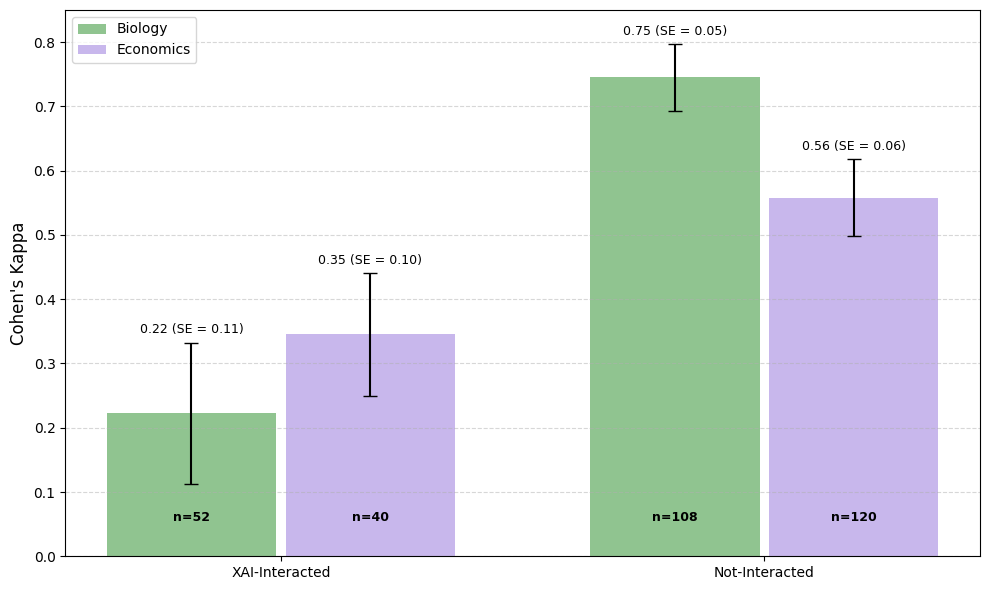

In [17]:
# Data preparation
subjects = ["Biology", "Economics"]

# Make bio 3 kappa 0 instead of -1
bio_interaction_df.loc[bio_interaction_df['Dataset'] == 'Biology 3', 'Kappa'] = 0.0

teacher_data = {
    "Biology": {
        "Interacted": {
            "Kappa": bio_interaction_df['Kappa'],
            "Sample_Size": bio_interaction_df['Sample Size']
        },
        "Not_Interacted": {
            "Kappa": not_interacted_bio_df['Kappa'],
            "Sample_Size": not_interacted_bio_df['Sample Size']
        },
        "color": "forestgreen"
    },
    "Economics": {
        "Interacted": {
            "Kappa": eco_interaction_df['Kappa'],
            "Sample_Size": eco_interaction_df['Sample Size']
        },
        "Not_Interacted": {
            "Kappa": not_interacted_eco_df['Kappa'],
            "Sample_Size": not_interacted_eco_df['Sample Size']
        },
        "color": "mediumpurple"
    }
}

# Calculate averages and standard errors for each subject and condition
avg_data = {}
for subject, data in teacher_data.items():
    avg_data[subject] = {
        "Interacted": {
            "Kappa": np.nanmean([k for k in data["Interacted"]["Kappa"] if k is not None]),
            "Sample_Size": sum(data["Interacted"]["Sample_Size"]),
            "SE": np.nanstd([k for k in data["Interacted"]["Kappa"] if k is not None]) / np.sqrt(sum(~np.isnan(data["Interacted"]["Kappa"])))
        },
        "Not_Interacted": {
            "Kappa": np.nanmean([k for k in data["Not_Interacted"]["Kappa"] if k is not None]),
            "Sample_Size": sum(data["Not_Interacted"]["Sample_Size"]),
            "SE": np.nanstd([k for k in data["Not_Interacted"]["Kappa"] if k is not None]) / np.sqrt(sum(~np.isnan(data["Not_Interacted"]["Kappa"])))
        }
    }

fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(2)
width = 0.35
spacing = 0.02 

# Plot Kappa values with error bars
for i, subject in enumerate(subjects):
    offset = (i - 0.5) * (width + spacing)

    yerr_interacted = avg_data[subject]["Interacted"]["SE"]
    yerr_not_interacted = avg_data[subject]["Not_Interacted"]["SE"]
    
    # Interacted condition with error bars
    bars1 = ax1.bar(x[0] + offset, avg_data[subject]["Interacted"]["Kappa"], 
                   width, label=f"{subject}", yerr=yerr_interacted, capsize=5,
                   color=teacher_data[subject]["color"], alpha=0.5)
    
    # Not-Interacted condition with error bars
    bars2 = ax1.bar(x[1] + offset, avg_data[subject]["Not_Interacted"]["Kappa"], 
                   width, yerr=yerr_not_interacted, capsize=5,
                   color=teacher_data[subject]["color"], alpha=0.5)
    
    # Add sample size annotations
    for bar, condition in zip([bars1[0], bars2[0]], ["Interacted", "Not_Interacted"]):
        sample_size = avg_data[subject][condition]["Sample_Size"]
        ax1.annotate(f'n={sample_size}', 
                    xy=(bar.get_x() + bar.get_width()/2, 0.05),
                    ha='center', va='bottom', 
                    color='black', fontweight='bold', fontsize=9)

ax1.set_ylabel("Cohen's Kappa", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(["XAI-Interacted", "Not-Interacted"])
ax1.set_ylim(0, 0.85)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend(loc='upper left')

# Add value labels right on top of the error bars
for i, subject in enumerate(subjects):
    offset = (i - 0.5) * (width + spacing)
    for j, condition in enumerate(["Interacted", "Not_Interacted"]):
        height = avg_data[subject][condition]["Kappa"]
        se = avg_data[subject][condition]["SE"]
        label_height = height + se + 0.01
        ax1.text(x[j] + offset, label_height,
                f'{height:.2f} (SE = {se:.2f})', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

### Compare interaction IRR per subject

In [18]:
def create_comparison_df(total_df, interaction_df, subject):
    """
    Create a DataFrame that pairs total and interaction metrics for each teacher.
    
    This function combines data from two DataFrames: one with overall teacher scoring metrics
    and another with metrics specifically from XAI-interacted responses. It produces a
    consolidated view that enables direct comparison between a teacher's general scoring
    performance and their performance on responses where they used XAI features.
    
    Parameters
    ----------
    total_df : pandas.DataFrame
        DataFrame containing overall teacher scoring metrics
        Must include 'Dataset', 'Kappa', and 'Agreement' columns
        
    interaction_df : pandas.DataFrame
        DataFrame containing teacher metrics only for XAI-interacted responses
        Must include 'Dataset', 'Kappa', 'Agreement', and optionally 'Sample Size' columns
        
    subject : str
        Subject identifier (e.g., "Biology" or "Economics") to include in output
        
    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - 'Teacher': Teacher identifier
        - 'Subject': Subject identifier
        - 'Total_Kappa': Cohen's Kappa from total dataset
        - 'Interaction_Kappa': Cohen's Kappa from interaction dataset
        - 'Kappa_Difference': Difference between interaction and total Kappa
        - 'Total_Agreement': Raw agreement from total dataset
        - 'Interaction_Agreement': Raw agreement from interaction dataset
        - 'Agreement_Difference': Difference between interaction and total agreement
        - 'Interaction_Sample_Size': Number of responses in the interaction dataset
    """
    
    teachers = [col.split('_')[0] if '_' in col else col for col in total_df['Dataset']]
    total_df_copy = total_df.copy()
    total_df_copy['Teacher'] = teachers
    
    interaction_teachers = [col.split('_')[0] if '_' in col else col for col in interaction_df['Dataset']]
    interaction_df_copy = interaction_df.copy()
    interaction_df_copy['Teacher'] = interaction_teachers
    
    comparison = []
    for teacher in set(teachers):
        total_row = total_df_copy[total_df_copy['Teacher'] == teacher]
        interaction_row = interaction_df_copy[interaction_df_copy['Teacher'] == teacher]
        
        if not total_row.empty and not interaction_row.empty:
            comparison.append({
                'Teacher': teacher,
                'Subject': subject,
                'Total_Kappa': total_row['Kappa'].values[0],
                'Interaction_Kappa': interaction_row['Kappa'].values[0],
                'Kappa_Difference': interaction_row['Kappa'].values[0] - total_row['Kappa'].values[0],
                'Total_Agreement': total_row['Agreement'].values[0],
                'Interaction_Agreement': interaction_row['Agreement'].values[0],
                'Agreement_Difference': interaction_row['Agreement'].values[0] - total_row['Agreement'].values[0],
                'Interaction_Sample_Size': interaction_row['Sample Size'].values[0] if 'Sample Size' in interaction_row else None
            })
    
    return pd.DataFrame(comparison)


all_rater_df = pd.concat([bio_rater_df, eco_rater_df], ignore_index=True)

bio_comparison = create_comparison_df(bio_rater_df, bio_interaction_df, "Biology")
eco_comparison = create_comparison_df(eco_rater_df, eco_interaction_df, "Economics")

all_comparison = pd.concat([bio_comparison, eco_comparison], ignore_index=True)
display(all_comparison)

,Teacher,Subject,Total_Kappa,Interaction_Kappa,Kappa_Difference,Total_Agreement,Interaction_Agreement,Agreement_Difference,Interaction_Sample_Size
0,Biology 2,Biology,0.712000,0.649351,-0.062649,0.859375,0.833333,-0.026042,18
1,Biology 5,Biology,0.498531,0.000000,-0.498531,0.750000,0.541667,-0.208333,12
2,Biology 3,Biology,0.680982,0.000000,-0.680982,0.846154,0.000000,-0.846154,1
3,Biology 1,Biology,0.652174,0.129032,-0.523142,0.828125,0.625000,-0.203125,12
4,Biology 4,Biology,0.480203,0.333333,-0.146870,0.750000,0.666667,-0.083333,9
5,Economics 5,Economics,0.363636,0.274112,-0.089525,0.750000,0.704545,-0.045455,22
6,Economics 3,Economics,0.278515,0.062500,-0.216015,0.734375,0.583333,-0.151042,6
7,Economics 4,Economics,0.503067,0.500000,-0.003067,0.777778,0.750000,-0.027778,2
8,Economics 1,Economics,0.507042,0.222222,-0.284820,0.821429,0.642857,-0.178571,7
9,Economics 2,Economics,0.582938,0.666667,0.083728,0.828125,0.833333,0.005208,3


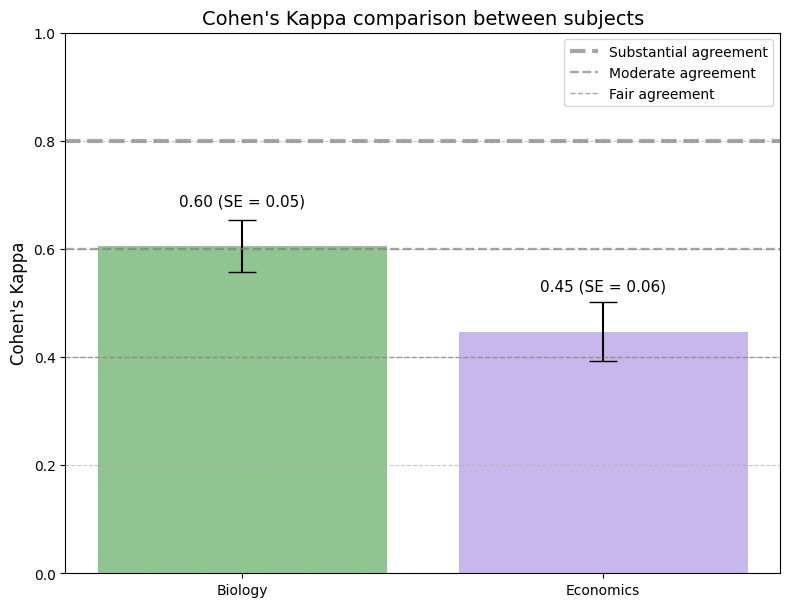

In [19]:
# Create and visualize Cohen's Kappa comparison between subject groups
group_stats = pd.DataFrame([
    {'Group': 'Biology', 
     'Kappa_Mean': bio_rater_df['Kappa'].mean(), 
     'Kappa_Std': bio_rater_df['Kappa'].std(),
     'Kappa_SE': bio_rater_df['Kappa'].std() / np.sqrt(len(bio_rater_df))},  
    {'Group': 'Economics', 
     'Kappa_Mean': eco_rater_df['Kappa'].mean(), 
     'Kappa_Std': eco_rater_df['Kappa'].std(),
     'Kappa_SE': eco_rater_df['Kappa'].std() / np.sqrt(len(eco_rater_df))}   
])

fig, ax1 = plt.subplots(figsize=(8, 6))
bars1 = ax1.bar(group_stats['Group'], group_stats['Kappa_Mean'], 
               yerr=group_stats['Kappa_SE'], capsize=10, 
               color=['forestgreen', 'mediumpurple'], alpha=0.5)
ax1.set_ylabel("Cohen's Kappa", fontsize=12)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add reference lines for Kappa interpretation
ax1.axhline(y=0.8, linestyle='--', color='gray', linewidth=3.0, alpha=0.7, label='Substantial agreement')
ax1.axhline(y=0.6, linestyle='--', color='gray', linewidth=1.7, alpha=0.7, label='Moderate agreement')
ax1.axhline(y=0.4, linestyle='--', color='gray', linewidth=1.0, alpha=0.7, label='Fair agreement')

# Add value labels on top of the bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    se = group_stats['Kappa_SE'].iloc[i]
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.07,
            f"{group_stats['Kappa_Mean'].iloc[i]:.2f} (SE = {se:.2f})", 
            ha='center', va='bottom', fontsize=11)

ax1.legend(loc='upper right')
plt.tight_layout()
plt.title("Cohen's Kappa comparison between subjects", fontsize=14)
plt.show()

### Cohen's Kappa per participant

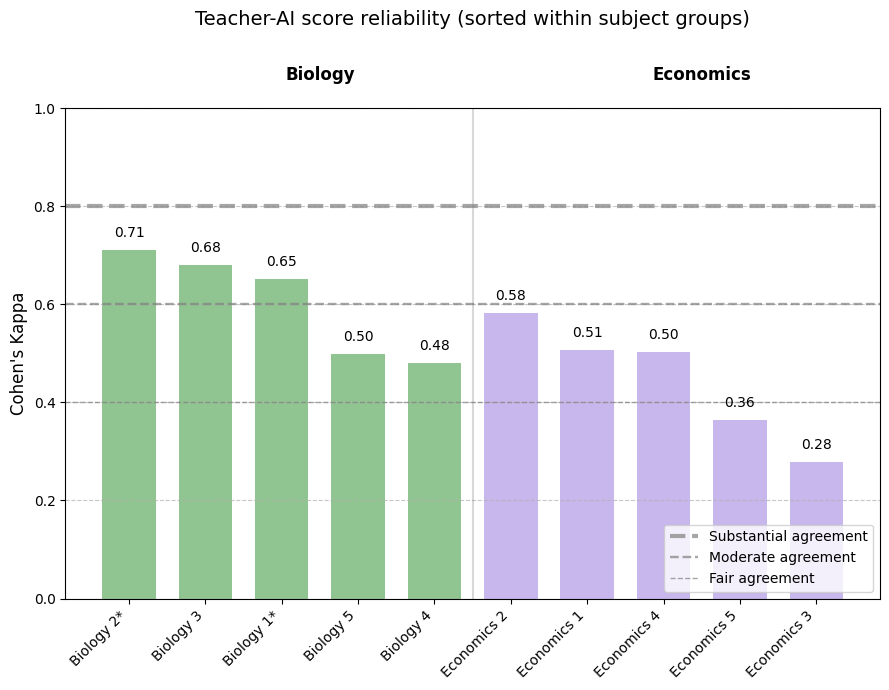

In [20]:
# This plot shows the Cohen's Kappa scores for each teacher, sorted within subject groups

bio_mask = all_rater_df['Dataset'].str.contains('Biology')
eco_mask = all_rater_df['Dataset'].str.contains('Economics')

# Split and sort datasets
bio_df = all_rater_df[bio_mask].sort_values(by='Kappa', ascending=False).reset_index(drop=True)
eco_df = all_rater_df[eco_mask].sort_values(by='Kappa', ascending=False).reset_index(drop=True)
sorted_kappa_df = pd.concat([bio_df, eco_df], ignore_index=True)

bio_df = all_rater_df[bio_mask].sort_values(by='Agreement', ascending=False).reset_index(drop=True)
eco_df = all_rater_df[eco_mask].sort_values(by='Agreement', ascending=False).reset_index(drop=True)
sorted_agreement_df = pd.concat([bio_df, eco_df], ignore_index=True)

# Get counts for group separation
bio_count = sum(bio_mask)
x = np.arange(len(all_rater_df))

# Create modified labels with asterisks for Biology 1 and Biology 2
modified_labels = sorted_kappa_df['Dataset'].copy()
for i, label in enumerate(modified_labels):
    if label == 'Biology 1' or label == 'Biology 2':
        modified_labels[i] = f"{label}*"

fig1 = plt.figure(figsize=(9, 7))
ax1 = fig1.add_subplot(111)

kappa_bars = ax1.bar(x, sorted_kappa_df['Kappa'], width=0.7, 
                    color=['forestgreen' if i < bio_count else 'mediumpurple' for i in range(len(sorted_kappa_df))], 
                    alpha=0.5)

ax1.axhline(y=0.8, linestyle='--', color='gray', linewidth=3.0, alpha=0.7, label='Substantial agreement')
ax1.axhline(y=0.6, linestyle='--', color='gray', linewidth=1.7, alpha=0.7, label='Moderate agreement')
ax1.axhline(y=0.4, linestyle='--', color='gray', linewidth=1.0, alpha=0.7, label='Fair agreement')

ax1.axvline(x=bio_count-0.5, color='gray', linestyle='-', alpha=0.3)
ax1.text(bio_count/2, 1.05, 'Biology', ha='center', va='bottom', 
        transform=ax1.get_xaxis_transform(), fontsize=12, fontweight='bold')
ax1.text(bio_count + (len(all_rater_df)-bio_count)/2, 1.05, 'Economics', 
        ha='center', va='bottom', transform=ax1.get_xaxis_transform(), 
        fontsize=12, fontweight='bold')

# Add value labels on bars
for bar in kappa_bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

ax1.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax1.set_title('Teacher-AI score reliability (sorted within subject groups)', fontsize=14, pad=60)
ax1.set_xticks(x)
ax1.set_xticklabels(modified_labels, rotation=45, ha='right')  
ax1.legend(loc='lower right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

## IRR type A vs. type B 

### Functions

In [21]:
def calculate_gray_vs_nongray_irr(datasets_dict, benchmark_scores, subject_name="Subject", 
                                 create_plot=True, display_results=True):
    """
    Calculate inter-rater reliability split by gray area (even student numbers) vs. 
    non-gray area (odd student numbers).
    
    Parameters:
    -----------
    datasets_dict : dict
        Dictionary of dataframes with teacher ratings
    benchmark_scores : pandas DataFrame
        DataFrame containing benchmark/AI scores to compare against
    subject_name : str
        Name of the subject for plot titles and result labels
    create_plot : bool
        Whether to generate comparison plots
    display_results : bool
        Whether to print and display detailed results
        
    Returns:
    --------
    tuple
        (gray_area_df, non_gray_area_df, comparison_df, figure)
        DataFrames with reliability statistics and matplotlib figure (if created)
    """
    gray_rater_statistics = {}
    nongray_rater_statistics = {}
    structured_datasets = {}

    for name, df in datasets_dict.items():
        if display_results:
            print(f"\n===== PROCESSING {name} =====")
            
        # Clean and structure the data
        structure_df = clean_teacher_scores(df)
        structured_datasets[name] = structure_df
        
        # Split the data based on student number parity
        gray_df = structure_df[structure_df['student_nr'] % 2 == 0].copy()
        nongray_df = structure_df[structure_df['student_nr'] % 2 != 0].copy()
        
        if display_results:
            print(f"Gray area students: {len(gray_df)}, Non-gray area students: {len(nongray_df)}")
        
        # Process gray area responses (even student numbers)
        if not gray_df.empty:
            gray_benchmark = benchmark_scores[benchmark_scores['student_nr'].isin(gray_df['student_nr'])]
            common_students = set(gray_df['student_nr']).intersection(set(gray_benchmark['student_nr']))

            if display_results:
                print(f"Gray area - Common students with benchmark: {len(common_students)} out of {len(gray_df)}")
            
            if not gray_benchmark.empty and len(common_students) > 0:
                if display_results:
                    print(f"\nGray area inter-rater reliability for {name}:")
                gray_rater_statistics[f"{name}_Gray"] = get_teacher_benchmark_reliability(
                    gray_df, gray_benchmark)
        
        # Process non-gray area responses (odd student numbers)
        if not nongray_df.empty:
            nongray_benchmark = benchmark_scores[benchmark_scores['student_nr'].isin(nongray_df['student_nr'])]
            common_students = set(nongray_df['student_nr']).intersection(set(nongray_benchmark['student_nr']))
            if display_results:
                print(f"Non-gray area - Common students with benchmark: {len(common_students)} out of {len(nongray_df)}")
            
            if not nongray_benchmark.empty and len(common_students) > 0:
                if display_results:
                    print(f"\nNon-gray area inter-rater reliability for {name}:")
                nongray_rater_statistics[f"{name}_NonGray"] = get_teacher_benchmark_reliability(
                    nongray_df, nongray_benchmark)
                
    # Convert the statistics to DataFrames
    gray_rater_df = stats_to_dataframe(gray_rater_statistics)
    nongray_rater_df = stats_to_dataframe(nongray_rater_statistics)
    
    # Display the results
    if display_results:
        print(f"\n===== {subject_name.upper()} GRAY AREA RELIABILITY =====")
        display(gray_rater_df)
        
        print(f"\n===== {subject_name.upper()} NON-GRAY AREA RELIABILITY =====")
        display(nongray_rater_df)
        
        print("\n===== SUMMARY STATISTICS =====")
        print(f"Gray Area - Mean Kappa: {gray_rater_df['Kappa'].mean():.4f}, Mean Agreement: {gray_rater_df['Agreement'].mean():.4f}")
        print(f"Non-Gray Area - Mean Kappa: {nongray_rater_df['Kappa'].mean():.4f}, Mean Agreement: {nongray_rater_df['Agreement'].mean():.4f}")
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Area': ['Type A responses', 'Type B responses'],
        'Kappa_Mean': [gray_rater_df['Kappa'].mean(), nongray_rater_df['Kappa'].mean()],
        'Kappa_Std': [gray_rater_df['Kappa'].std(), nongray_rater_df['Kappa'].std()],
        'Agreement_Mean': [gray_rater_df['Agreement'].mean(), nongray_rater_df['Agreement'].mean()],
        'Agreement_Std': [gray_rater_df['Agreement'].std(), nongray_rater_df['Agreement'].std()]
    })
    
    # Create comparison plot if requested
    fig = None
    if create_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        if subject_name.lower() == "biology":
            colors = ['silver', 'dimgray']
        elif subject_name.lower() == "economics":
            colors = ['silver', 'dimgray']
        
        # Kappa plot
        bars1 = ax1.bar(comparison_df['Area'], comparison_df['Kappa_Mean'], 
                       yerr=comparison_df['Kappa_Std'], capsize=10, 
                       color=colors)
        ax1.set_title(f"{subject_name}: Cohen's Kappa by Response Ambiguity", fontsize=14)
        ax1.set_ylabel("Kappa Value", fontsize=12)
        ax1.set_ylim(0, 1)
        ax1.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Agreement plot
        bars2 = ax2.bar(comparison_df['Area'], comparison_df['Agreement_Mean'], 
                       yerr=comparison_df['Agreement_Std'], capsize=10,
                       color=colors)
        ax2.set_title(f"{subject_name}: Agreement by Response Ambiguity", fontsize=14)
        ax2.set_ylabel("Agreement Value", fontsize=12)
        ax2.set_ylim(0, 1)
        ax2.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on bars
        for ax, bars, column in [(ax1, bars1, 'Kappa_Mean'), (ax2, bars2, 'Agreement_Mean')]:
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2.6, height + 0.02,
                        f"{comparison_df[column].iloc[i]:.2f}", ha='center', va='bottom', fontsize=11)
        
        plt.tight_layout()
        if display_results:
            plt.show()
    
    return gray_rater_df, nongray_rater_df, comparison_df, fig

In [22]:
def create_combined_comparison_plot(bio_comparison, eco_comparison):
    """
    Create a combined bar plot comparing Cohen's Kappa values between response types for Biology and Economics.
    
    Parameters
    ----------
    bio_comparison : pandas.DataFrame
        DataFrame containing biology reliability statistics with columns:
        - 'Area': Labels for response types ('Type A responses', 'Type B responses')
        - 'Kappa_Mean': Mean Cohen's Kappa values for each response type
        - 'Kappa_Std': Standard deviations for the Kappa values
        
    eco_comparison : pandas.DataFrame
        DataFrame containing economics reliability statistics with the same structure
        as bio_comparison
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the grouped bar chart comparing Kappa values
        across subject domains and response types with standard error bars
        
    Notes
    -----
    - Standard errors are calculated assuming n=5 teachers per subject domain
    - Value labels show both the mean value and standard error
    """

    fig_kappa = plt.figure(figsize=(12, 6))
    ax_kappa = fig_kappa.add_subplot(111)
    
    bio_colors = ['forestgreen', 'forestgreen']
    eco_colors = ['mediumpurple', 'mediumpurple']
    
    x = np.arange(2)
    width = 0.35
    
    bio_se = [
        bio_comparison['Kappa_Std'][0] / np.sqrt(5),  # SE for Type A responses (assuming n=5 teachers)
        bio_comparison['Kappa_Std'][1] / np.sqrt(5)   # SE for Type B responses (assuming n=5 teachers)
    ]
    
    eco_se = [
        eco_comparison['Kappa_Std'][0] / np.sqrt(5),  # SE for Type A responses (assuming n=5 teachers)
        eco_comparison['Kappa_Std'][1] / np.sqrt(5)   # SE for Type B responses (assuming n=5 teachers)
    ]
    
    bars1 = ax_kappa.bar(x - width/2, bio_comparison['Kappa_Mean'], width, 
                  yerr=bio_se, capsize=10,
                  color=bio_colors, alpha=0.5, label='Biology')
    bars2 = ax_kappa.bar(x + width/2, eco_comparison['Kappa_Mean'], width,
                  yerr=eco_se, capsize=10,
                  color=eco_colors, alpha=0.5, label='Economics')

    ax_kappa.set_ylabel("Cohen's Kappa", fontsize=14)
    ax_kappa.set_xticks(x)
    ax_kappa.set_xticklabels(bio_comparison['Area'])
    ax_kappa.set_ylim(0, 1)
    ax_kappa.legend()
    ax_kappa.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of the bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        se = bio_se[i]
        if i == 0:
            extra_height = 0.11
        else:
            extra_height = 0.06
        ax_kappa.text(bar.get_x() + bar.get_width()/2, height + extra_height,
                f"{height:.2f} (SE = {se:.2f})", 
                ha='center', va='bottom', fontsize=10)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        se = eco_se[i]
        if i == 1:
            extra_height = 0.11
        else:
            extra_height = 0.1
        ax_kappa.text(bar.get_x() + bar.get_width()/2, height + extra_height,
                f"{height:.2f} (SE = {se:.2f})", 
                ha='center', va='bottom', fontsize=10)
    
    return fig_kappa

### Plots

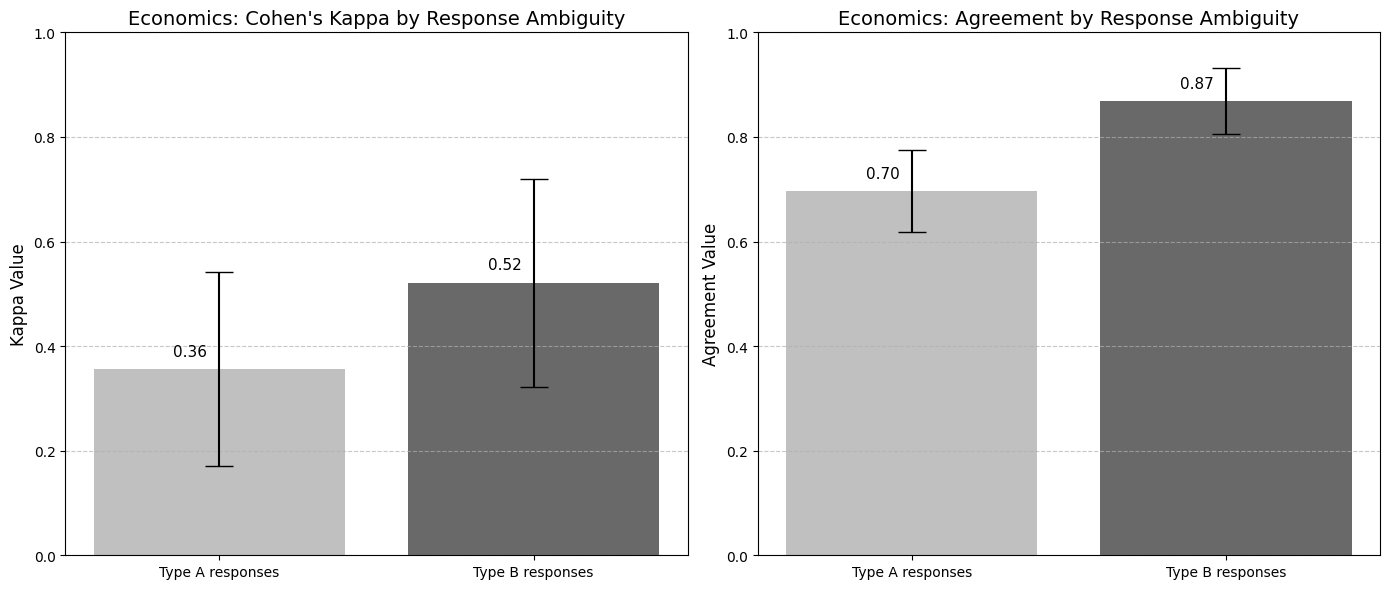

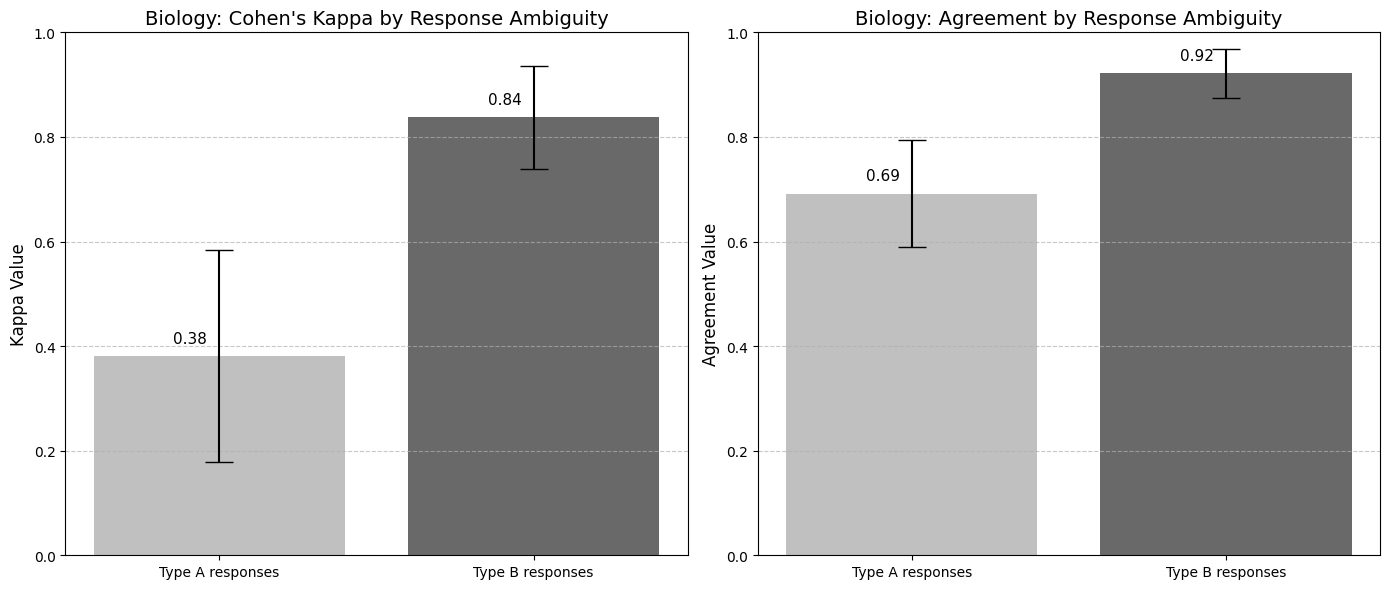

In [23]:
# Usage for Economics
eco_gray_df, eco_nongray_df, eco_comparison, eco_fig = calculate_gray_vs_nongray_irr(
    eco_datasets, eco_scores, subject_name="Economics", display_results=False)

# Usage for Biology
bio_gray_df, bio_nongray_df, bio_comparison, bio_fig = calculate_gray_vs_nongray_irr(
    bio_datasets, bio_scores, subject_name="Biology", display_results=False)


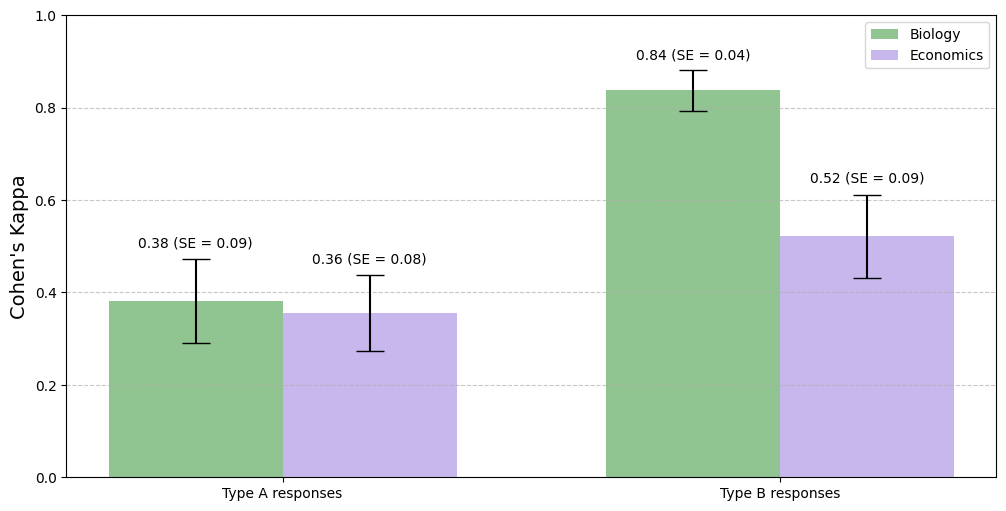

In [24]:
kappa_fig = create_combined_comparison_plot(bio_comparison, eco_comparison)

In [25]:
# Combined Cohen's Kappa statistics
display(eco_comparison)
display(bio_comparison)


,Area,Kappa_Mean,Kappa_Std,Agreement_Mean,Agreement_Std
0,Type A responses,0.356020,0.184899,0.696429,0.077837
1,Type B responses,0.521379,0.198959,0.868132,0.063429


,Area,Kappa_Mean,Kappa_Std,Agreement_Mean,Agreement_Std
0,Type A responses,0.381024,0.202797,0.691346,0.102179
1,Type B responses,0.837304,0.099020,0.922115,0.046878
